In [1]:
# load the relevant modules for the analysis

from pl_temp_fit import Exp_data_utils

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import os
import json
import uuid
import numpy as np
from pl_temp_fit import config_utils
from pl_temp_fit import covariance_utils, generate_data_utils, fit_EL_utils
import emcee

os.chdir('/rds/general/user/ma11115/home/pl_temp_fit/') 
# access the right directory
#os.chdir('C:\\Users\\ma11115\\OneDrive - Imperial College London\\pl_temp_fit')

## load a test sample

In [2]:
import importlib
importlib.reload(config_utils)
test_id = '7ec32554-4e8e-4830-a15d-203c341d6fd2'
model_config, model_config_save = config_utils.load_model_config(test_id, database_folder = "fit_experimental_emcee_PL/fit_data_base/")
filename = model_config_save['save_folder'] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)  


In [19]:
model_config['temperature_list_PL'][-1]

300.0

number of iterations 10020


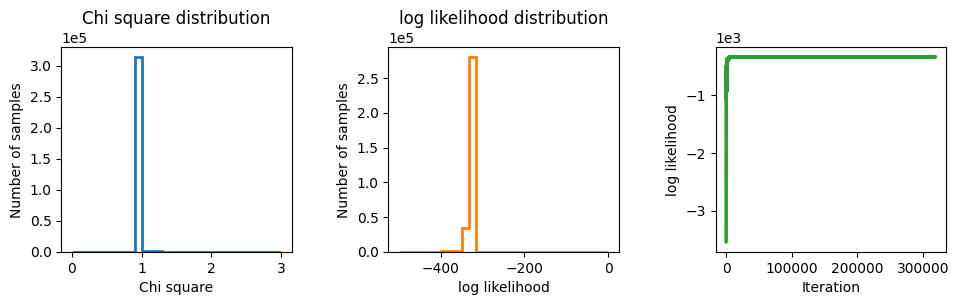

In [42]:
def plot_fit_statistics(reader,range_chi_square = (0,3), range_log_prior = (-1000,0),discard = 5):
    print('number of iterations', reader.iteration)
    blobs = reader.get_blobs(flat=True,discard = discard)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].hist(blobs['Chi square'], 30, color="C" + str(0),
        linewidth=2, histtype="step", range=range_chi_square)
    ax[0].set_xlabel("Chi square")
    ax[0].set_ylabel("Number of samples")
    ax[0].set_title('Chi square distribution')
    ax[1].hist(blobs['log_likelihood'], 30, color="C" + str(1),
        linewidth=2, histtype="step", range=range_log_prior)
    ax[1].set_xlabel("log likelihood")
    ax[1].set_ylabel("Number of samples")
    ax[1].set_title('log likelihood distribution')
    ax[2].plot(blobs['log_likelihood'],color="C" + str(2),
        linewidth=2,)
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("log likelihood")
    fig.tight_layout()
    for i in range(3):
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    plt.show()
plot_fit_statistics(reader,range_log_prior = (-500,0),discard=50,range_chi_square = (0,3))

number of iterations 10020


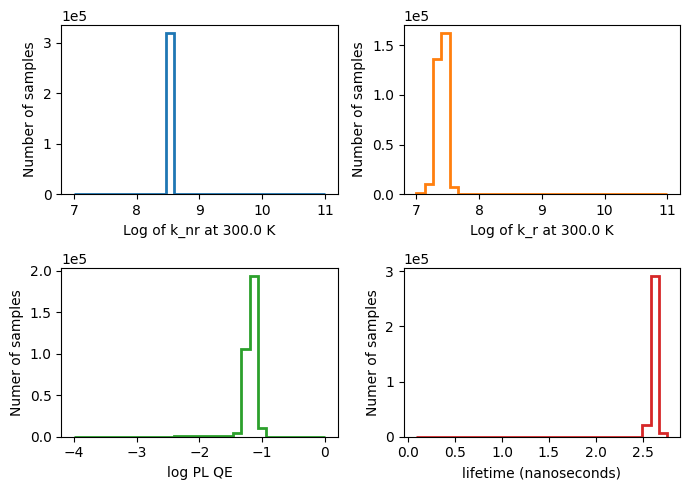

In [36]:
def plot_lifetime(
    reader,
    range_chi_square=(7, 11),
    range_log_prior=(7, 11),
    discard=5,
    temperature=model_config["temperature_list_PL"][-1],
):
    print("number of iterations", reader.iteration)
    blobs = reader.get_blobs(flat=True, discard=discard)
    fig, ax = plt.subplots(2, 2, figsize=(7, 5))

    ax = ax.flatten()
    ax[0].hist(
        np.log10(blobs["Ex_knr"]),
        30,
        histtype="step",
        range=range_chi_square,
        color="C" + str(0),
        linewidth=2,
    )
    ax[0].set_xlabel("Log of k_nr at " + str(temperature) + " K")
    ax[0].set_ylabel("Number of samples")
    ax[1].hist(
        np.log10(blobs["Ex_kr"]),
        30,
        histtype="step",
        range=range_log_prior,
        color="C" + str(1),
        linewidth=2,
    )
    ax[1].set_xlabel("Log of k_r at " + str(temperature) + " K")
    ax[1].set_ylabel("Number of samples")
    PL_QE = blobs["Ex_kr"] / (blobs["Ex_kr"] + blobs["Ex_knr"])
    ax[2].hist(
        np.log10(PL_QE), 30, histtype="step", range=(-4, 0), color="C" + str(2),
        linewidth=2,
    )
    ax[2].set_xlabel("log PL QE")
    ax[2].set_ylabel("Numer of samples")
    lifetime = 1 / (blobs["Ex_kr"] + blobs["Ex_knr"])
    ax[3].hist(lifetime * 1e9, 30, histtype="step", color="C" + str(3),
               linewidth=2,)
    ax[3].set_xlabel("lifetime (nanoseconds)")
    ax[3].set_ylabel("Numer of samples")
    # set y ticks to exponent form
    for i in range(4):
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    fig.tight_layout()
    plt.show()


plot_lifetime(reader, discard=50)

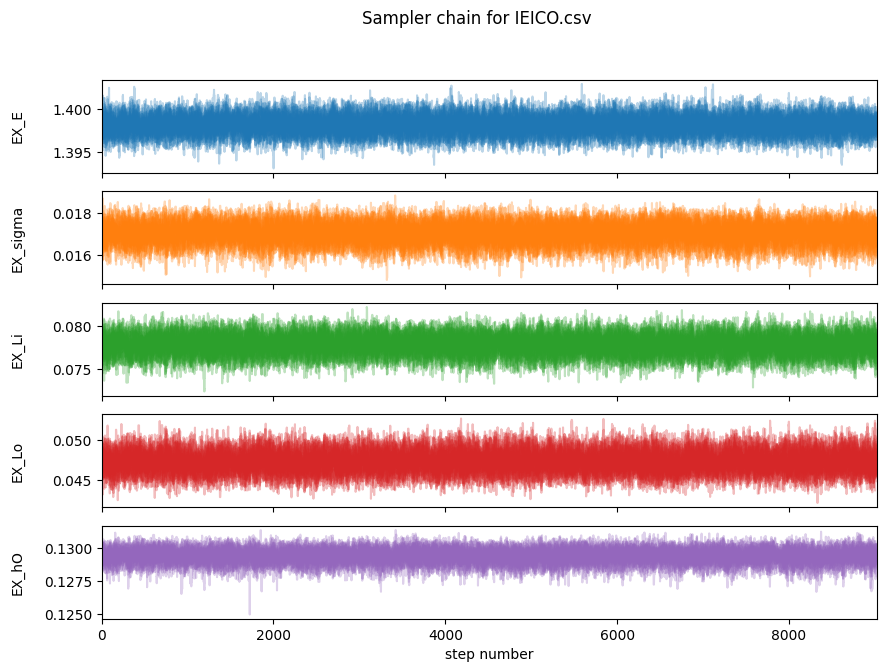

In [26]:

def plot_chains(reader,model_config_save,discard= 50):
    csv_name = model_config_save['csv_name_PL']
    label_list = []
    for key in model_config_save['params_to_fit_init'].keys():
        label_list.extend([key+'_' +x for x in model_config_save['params_to_fit_init'][key].keys()])
    labels= label_list
    fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
    samples = reader.get_chain(discard=discard)
    #labels = ["E", "sigma_E", "LI", "L0", "H0"]
    ndim = len(labels)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], alpha=0.3,color="C" + str(i))
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    fig.suptitle(f"Sampler chain for {csv_name.split('/')[-1]}")
    fig.show()
plot_chains(reader,model_config_save,discard=1000)

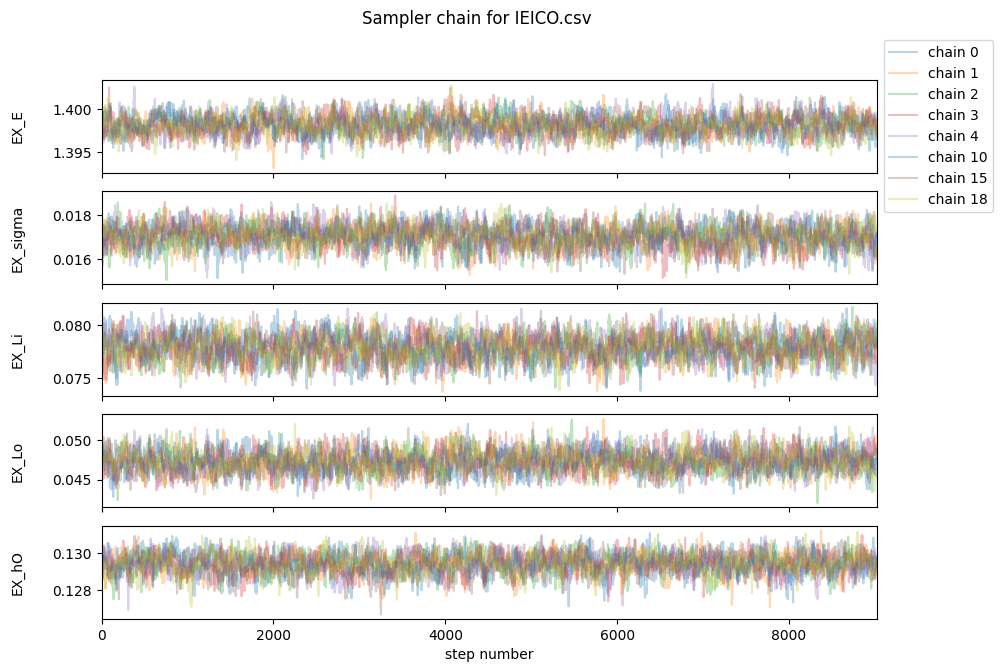

In [56]:
def plot_diff_chains(reader,model_config_save,discard= 50,chains_list = [0,1,2,3,4]):
    csv_name = model_config_save['csv_name_PL']
    label_list = []
    for key in model_config_save['params_to_fit_init'].keys():
        label_list.extend([key+'_' +x for x in model_config_save['params_to_fit_init'][key].keys()])
    labels= label_list
    fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
    samples = reader.get_chain(discard=discard)
    #labels = ["E", "sigma_E", "LI", "L0", "H0"]
    ndim = len(labels)
    for i in range(ndim):
        ax = axes[i]
        for j in chains_list:
            
            ax.plot(samples[:, j, i], alpha=0.3,color="C" + str(j),label = f'chain {j}')
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    # set legend outside the plot
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[-1].set_xlabel("step number")
    fig.suptitle(f"Sampler chain for {csv_name.split('/')[-1]}")
    fig.show()
plot_diff_chains(reader,model_config_save,discard=1000,chains_list = [0,1,2,3,4,10,15,18])

shape of mean value plot is (86, 8)


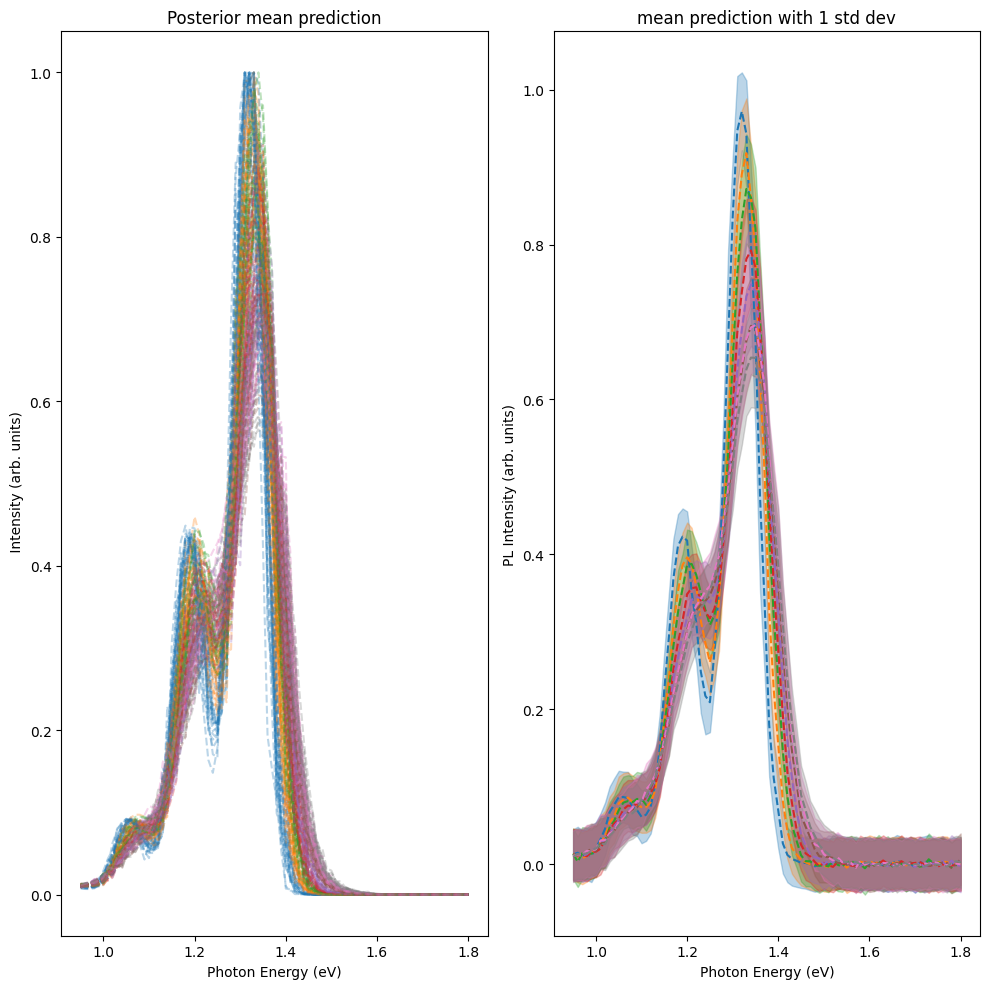

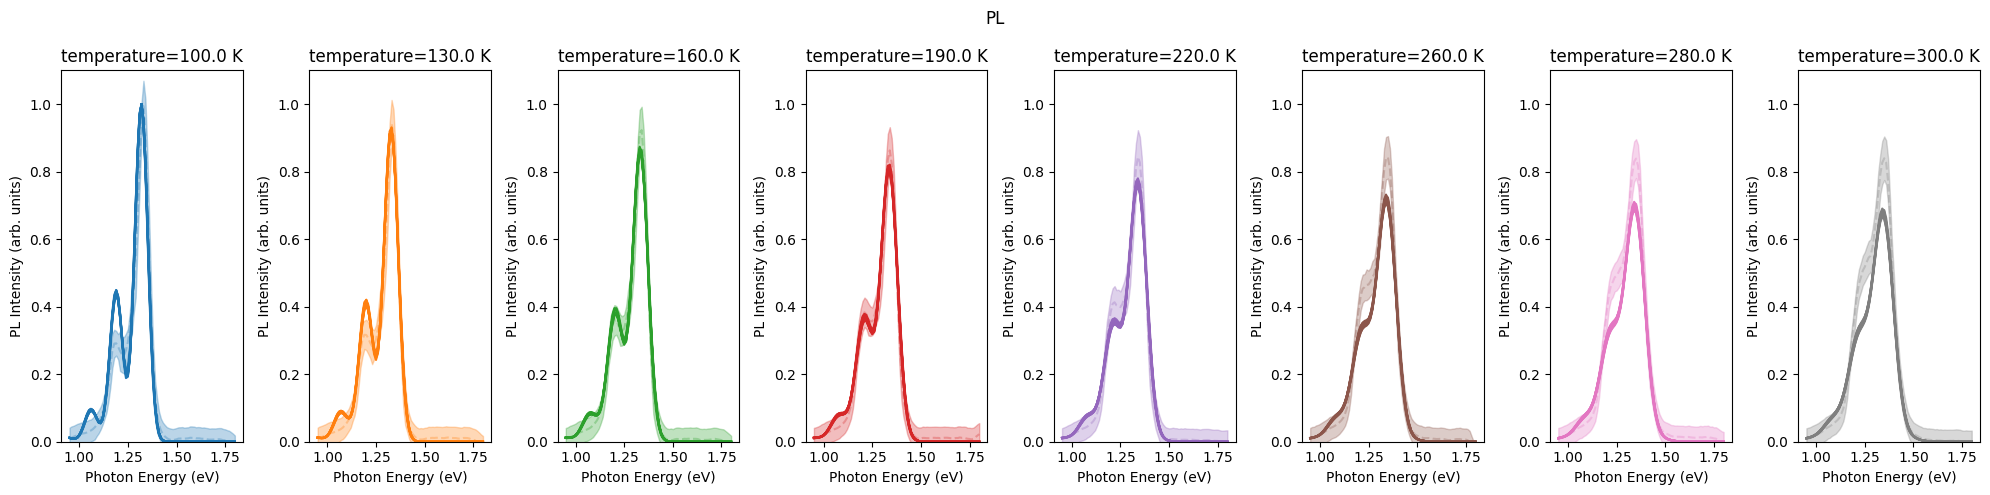

In [57]:
from pl_temp_fit import fit_PL_utils
importlib.reload(fit_PL_utils)
importlib.reload(covariance_utils)
def plot_fit_to_experimental_data(model_config_save,reader,discard=10,chains_list = None):
    Temp_std_err = model_config_save['Temp_std_err']
    hws_std_err = model_config_save['hws_std_err']
    relative_intensity_std_error_PL = model_config_save['relative_intensity_std_error_PL']
    sigma = model_config_save['sigma']
    save_folder = model_config_save['save_folder']
    fixed_parameters_dict = model_config_save['fixed_parameters_dict']
    params_to_fit_init = model_config_save['params_to_fit_init']
    min_bounds = model_config_save['min_bounds']
    max_bounds = model_config_save['max_bounds']
    csv_name = model_config_save['csv_name_PL']
    Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
    distribution = reader.get_chain(discard=discard)  
    if chains_list is not None:
        distribution = distribution[:,chains_list,:].reshape(-1,distribution.shape[-1])
    else:
        distribution = distribution.reshape(-1,distribution.shape[-1])
    true_parameters = fit_PL_utils.get_param_dict(params_to_fit_init,distribution[-1]) # model_config_save['params_to_fit_init']#
    co_var_mat_PL, variance_PL = (
        covariance_utils.plot_generated_data_PL(
            save_folder,
            model_config,
            savefig=True,
            fixed_parameters_dict=fixed_parameters_dict,
            params_to_fit=true_parameters,
        )
    )
    fig, ax = fit_PL_utils.plot_exp_data_with_variance(
            temperature_list,
            hws,
            variance_PL,
            save_folder,
            fixed_parameters_dict,
            true_parameters,
            Exp_data,
        )
    for true_parameters in distribution[np.random.choice(len(distribution),10),:]:

        true_parameters = fit_PL_utils.get_param_dict(params_to_fit_init, true_parameters)

        fig,ax = fit_PL_utils.plot_exp_data_with_variance(
            temperature_list,
            hws,
            variance_PL,
            save_folder,
            fixed_parameters_dict,
            true_parameters,
            Exp_data,
            fig=fig,
            axis=ax
        )

    # delete legend from ax
    for axis in ax:
        axis.get_legend().remove()
plot_fit_to_experimental_data(model_config_save,reader,discard=1000)

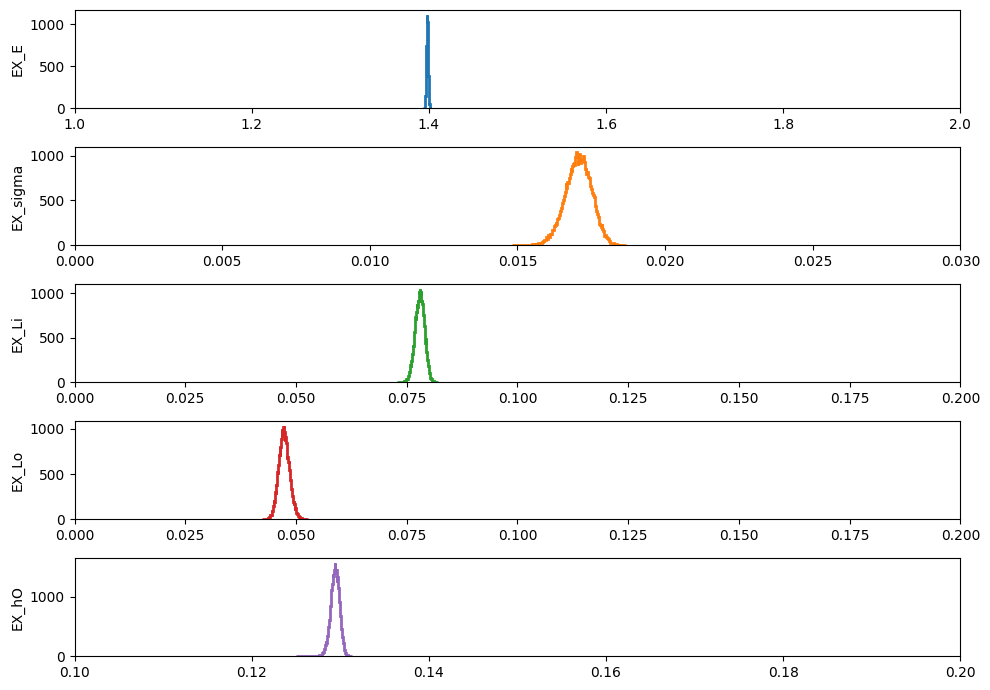

In [43]:

def plot_distribution(reader,model_config_save,discard=10):
    csv_name = model_config_save['csv_name_PL']
    label_list = []
    for key in model_config_save['params_to_fit_init'].keys():
        label_list.extend([key+'_' +x for x in model_config_save['params_to_fit_init'][key].keys()])
    labels= label_list
    samples = reader.get_chain()
    #labels = ["E", "sigma_E", "LI", "L0", "H0"]
    ndim = len(labels)

    #flat_samples.shape
    distribution = reader.get_chain(discard=discard, thin=5, flat=True)
    true_parameters=list(np.mean(distribution,axis=0))
    #print(flat_samples.shape)
    fig, axes = plt.subplots(5, figsize=(10, 7))
    axes_xlim = [[1,2],[0,0.03],[0,0.2],[0,0.2],[0.1,0.2]]
    for i in range(ndim):
        ax = axes[i]
        ax.hist(distribution[:, i], 200,
                color="C" + str(i),
                linewidth=2,
                histtype="step")
        ax.set_ylabel(labels[i])
        ax.set_xlim(axes_xlim[i])
    fig.tight_layout()
    #fig.show()
plot_distribution(reader,model_config_save,discard=1000)

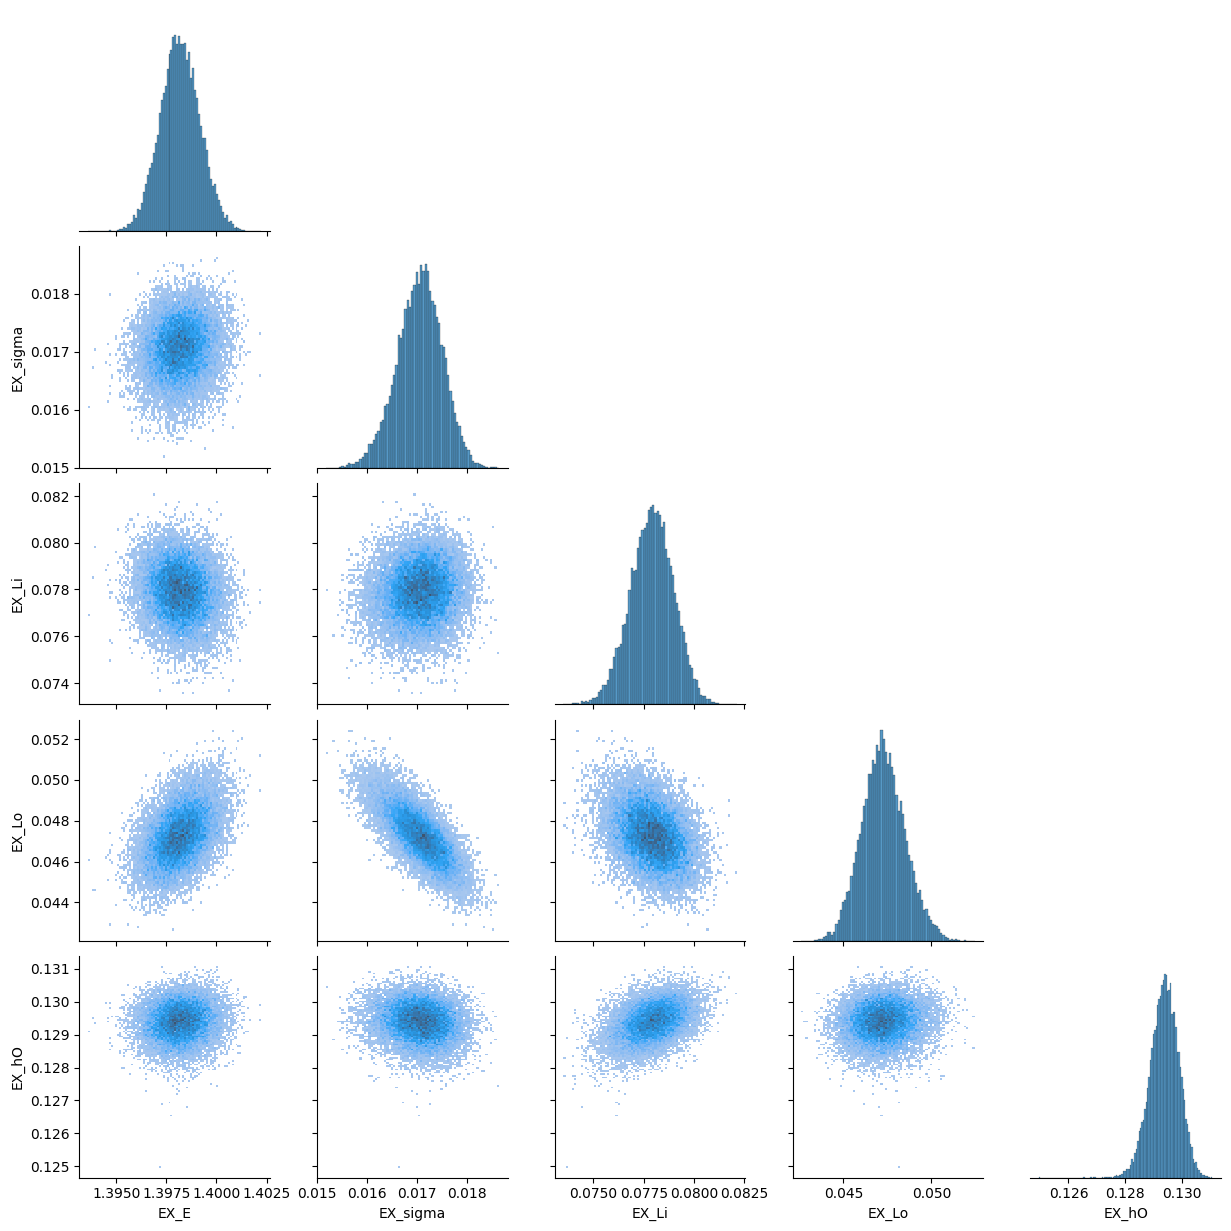

In [46]:
import seaborn as sns
import pandas as pd
def plot_corner(reader,model_config_save,discard=10):
    csv_name = model_config_save['csv_name_PL']
    label_list = []
    for key in model_config_save['params_to_fit_init'].keys():
        label_list.extend([key+'_' +x for x in model_config_save['params_to_fit_init'][key].keys()])
    labels= label_list
    samples = reader.get_chain(discard=discard, thin=15, flat=True)
    df_samples = pd.DataFrame(samples, columns=labels)
    g = sns.pairplot(df_samples, kind="hist", corner=True)
plot_corner(reader,model_config_save,discard=1000)

# rerun sampling 

In [12]:
Temp_std_err = model_config_save['Temp_std_err']
hws_std_err = model_config_save['hws_std_err']
relative_intensity_std_error_PL = model_config_save['relative_intensity_std_error_PL']
sigma = model_config_save['sigma']
save_folder = model_config_save['save_folder']
fixed_parameters_dict = model_config_save['fixed_parameters_dict']
params_to_fit_init = model_config_save['params_to_fit_init']
min_bounds = model_config_save['min_bounds']
max_bounds = model_config_save['max_bounds']
csv_name = model_config_save['csv_name_PL']
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

shape of mean value plot is (86, 8)


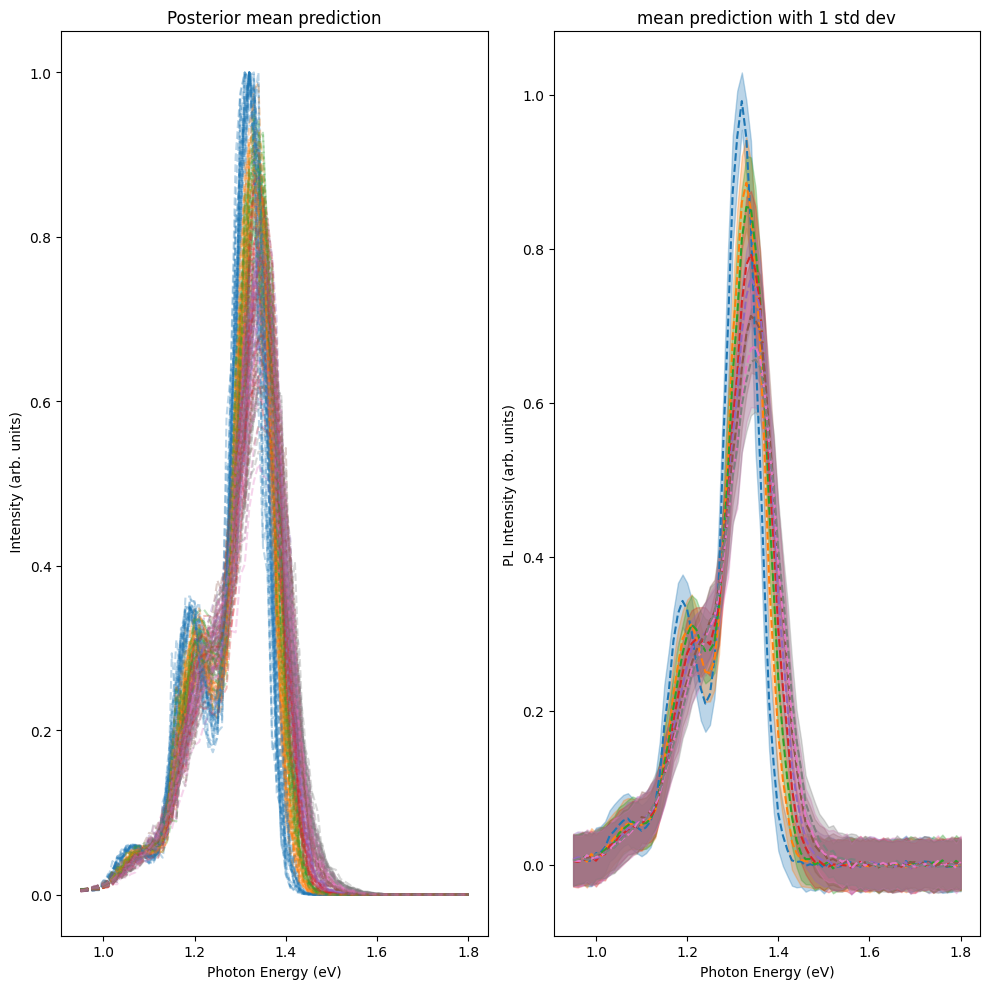

In [13]:
from pl_temp_fit import fit_PL_utils
true_parameters = fit_PL_utils.get_param_dict(params_to_fit_init,distribution[-1]) # model_config_save['params_to_fit_init']#
co_var_mat_PL, variance_PL = (
    covariance_utils.plot_generated_data_PL(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
)

In [14]:
from pl_temp_fit import fit_PL_utils, Emcee_utils
importlib.reload(generate_data_utils)
importlib.reload(covariance_utils)
importlib.reload(fit_PL_utils)
importlib.reload(Emcee_utils)
fit_PL_utils.run_sampler_parallel(
    save_folder,
    Exp_data,
    co_var_mat_PL,
    params_to_fit_init,
    fixed_parameters_dict,
    min_bounds,
    max_bounds,
    model_config,
    nsteps=5,
    coeff_spread=1,
    num_coords = 32,
    restart_sampling=False,
    num_processes=16,
)


Initial size: 88


You must install the tqdm library to use progress indicators with emcee


multi process took 10.4 seconds


## Run sampling in the HPC

In [22]:

model_config_id = test_id
csv_name = model_config_save['csv_name_PL']
results_name = csv_name.replace('.csv','').split('/')[-1]
sh_name = f"Run_EMCEE_{results_name}.sh"
script="#!/bin/bash \n"+\
    "#PBS -l walltime=07:59:01 \n"+\
    "#PBS -l select=1:ncpus=32:mem=80gb:avx=true \n"+\
    " \n"+\
    "cd /rds/general/user/ma11115/home/pl_temp_fit/ \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate pl_temp_fit     \n"+\
    f"python src/pl_temp_fit/scripts/run_PL_sampling.py --model_config_id {model_config_id} \n"#${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
#print(script) 
with open(f'HPC_bash_script/{sh_name}', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  
script= f"qsub  -e ./cache -o ./cache HPC_bash_script/{sh_name}"#submit to HPC
os.system(script)

9525494.pbs


sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: module: line 1: syntax error: unexpected end of file
sh: error importing function definition for `module'
sh: scl: line 1: syntax error: unexpected end of file
sh: error importing function definition for `scl'
sh: ml: line 1: syntax error: unexpected end of file
sh: error importing function definition for `ml'
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: 

0